<a href="https://colab.research.google.com/github/jadesola123/hamoye-stageE/blob/main/Hamoye_Stage_E.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
#Installing Facebook Prophet library
!pip install pystan~=2.14
!pip install fbprophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 67.3 MB 132 kB/s 
  Attempting uninstall: pystan
    Found existing installation: pystan 3.3.0
    Uninstalling pystan-3.3.0:
      Successfully uninstalled pystan-3.3.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 64 kB 2.4 MB/s 
  Created wheel for fbprophet: filename=fbprophet-0.7.1-py3-none-any.whl size=6639396 sha256=62840c80a44eb0bc52fa87d7fbfe0693ebd6618f50ff7663881ebde17c793479
  Stored in directory: /root/.cache/pip/wheels/cd/a1/12/db63ff624de492fe6cccf676091a0860fdde2ffde4bc3280e2
Successfully built fbprophet
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 1.0.7
    Uninstalling cmdstanpy-1.0.7:
      Successfully uninstalled cmdstanpy-1.0.7
ERROR: pip's dependency resolver does not currently take into account all the 

In [8]:
''' importing libraries'''
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from fbprophet import Prophet

In [11]:
#Reading the dataset
import pandas as pd
from fbprophet import Prophet
df = pd.read_csv('/Time_series_analysis_and_forecast_DATASET.csv')
df.head()

,FullDate,Tmax,SysLoad,GasPrice,ElecPrice
0,2010-09-01 00:00:00,15.8,1688.215,3.69,23.710
1,2010-09-01 01:00:00,15.8,1669.195,3.69,22.635
2,2010-09-01 02:00:00,15.8,1491.980,3.69,22.565
3,2010-09-01 03:00:00,15.8,1330.760,3.69,18.910
4,2010-09-01 04:00:00,15.8,1247.940,3.69,18.030


In [12]:
#Convert FullDate to datetime format and set as index
df['FullDate'] = pd.to_datetime(df['FullDate'])
df.set_index('FullDate', inplace = True)
df.head()

,Tmax,SysLoad,GasPrice,ElecPrice
FullDate,,,,
2010-09-01 00:00:00,15.8,1688.215,3.69,23.710
2010-09-01 01:00:00,15.8,1669.195,3.69,22.635
2010-09-01 02:00:00,15.8,1491.980,3.69,22.565
2010-09-01 03:00:00,15.8,1330.760,3.69,18.910
2010-09-01 04:00:00,15.8,1247.940,3.69,18.030


In [13]:
#Check for missing values
df.isnull().sum()

Tmax         0
SysLoad      0
GasPrice     0
ElecPrice    0
dtype: int64

In [14]:
#Downsampling from hours to days (i.e, daily sampling rate)
df_day = df.resample('M').mean()
df_day.head()

,Tmax,SysLoad,GasPrice,ElecPrice
FullDate,,,,
2010-09-30,16.906667,1578.145819,3.578663,25.075896
2010-10-31,21.377419,1398.027708,2.799987,22.223629
2010-11-30,24.323333,1484.759104,2.321943,22.575944
2010-12-31,26.696774,1082.167586,2.401429,17.585753
2011-01-31,30.629032,1331.477822,2.917977,103.094603


In [15]:
#ADF test for stationarity
from statsmodels.tsa.stattools import adfuller
result = adfuller(df_day['GasPrice'])
print(f'ADF Statistic = {result[0]}')
print(f'p-value of SysLoad to 6 decimal places = {round(result[1], 6)}')
print('critical values are: ')
for k, v in result[4].items():
    print(f'{k} : {v}')

ADF Statistic = -1.7019939817423997
p-value of SysLoad to 6 decimal places = 0.430085
critical values are: 
1% : -3.485585145896754
5% : -2.885738566292665
10% : -2.5796759080663887


In [16]:
result = adfuller(df_day['ElecPrice'])
print(f'ADF Statistic = {result[0]}')
print(f'p-value = {round(result[1], 6)}')
print(f'Number of lags used = {result[2]}')
print(f'Number of Observations = {result[3]}')
print('critical values are: ')
for k, v in result[4].items():
    print(f'{k} : {v}')

ADF Statistic = -3.8539708618723143
p-value = 0.002401
Number of lags used = 1
Number of Observations = 124
critical values are: 
1% : -3.484219653271961
5% : -2.885145235641637
10% : -2.579359138917794


In [17]:
#Resetting index and creating new data set
df_day_copy = df_day.copy().reset_index()
df_day_copy = df_day_copy[['FullDate', 'ElecPrice']].rename(columns = {'FullDate' : 'ds', 'ElecPrice' : 'y'})
df_day_copy.head()

,ds,y
0,2010-09-30,25.075896
1,2010-10-31,22.223629
2,2010-11-30,22.575944
3,2010-12-31,17.585753
4,2011-01-31,103.094603


In [18]:
#Split dataset into train(first 2757) and test (x-2757), where x = length of dataset
x_train, x_test = df_day_copy[:2757], df_day_copy[2757:]
y_train, y_test = df_day_copy.y[:2757], df_day_copy.y[2757:]

In [20]:
#Training model using the Facebook Prophet module
model = Prophet()
model.fit(x_train)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [21]:
#Predicting using the length of test dataset
future = model.make_future_dataframe(len(x_test), freq = 'D')
forecast = model.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2010-09-30,38.105274,-14.861759,67.777751,38.105274,38.105274,-10.432207,-10.432207,-10.432207,-10.432207,-10.432207,-10.432207,0.0,0.0,0.0,27.673066
1,2010-10-31,38.635501,-15.200788,69.534386,38.635501,38.635501,-12.554790,-12.554790,-12.554790,-12.554790,-12.554790,-12.554790,0.0,0.0,0.0,26.080711
2,2010-11-30,39.148625,-14.487778,67.027190,39.148625,39.148625,-11.736193,-11.736193,-11.736193,-11.736193,-11.736193,-11.736193,0.0,0.0,0.0,27.412432
3,2010-12-31,39.678853,-9.755069,73.286259,39.678853,39.678853,-6.777847,-6.777847,-6.777847,-6.777847,-6.777847,-6.777847,0.0,0.0,0.0,32.901006
4,2011-01-31,40.209080,22.250693,105.265860,40.209080,40.209080,21.214084,21.214084,21.214084,21.214084,21.214084,21.214084,0.0,0.0,0.0,61.423164


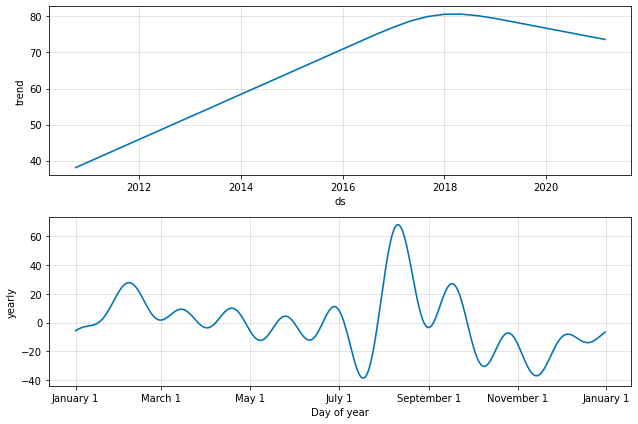

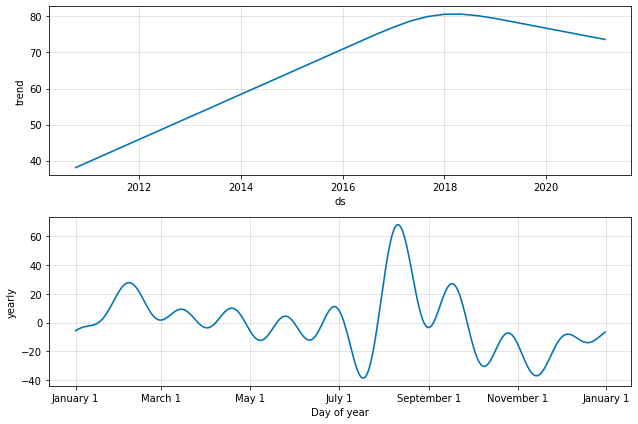

In [22]:
model.plot_components(forecast)

In [28]:
#Second training of model using regressors (SysLoad, Tmax and GasPrice as new1, new2 and new3 respectively)
df_reg = df_day.copy().reset_index()
df_reg = df_reg.rename(columns = {'FullDate' : 'ds', 'ElecPrice' : 'y', 'SysLoad' : 'new1', 'Tmax' : 'new2', 'GasPrice' : 'new3'})
df_reg.head()

,ds,new2,new1,new3,y
0,2010-09-30,16.906667,1578.145819,3.578663,25.075896
1,2010-10-31,21.377419,1398.027708,2.799987,22.223629
2,2010-11-30,24.323333,1484.759104,2.321943,22.575944
3,2010-12-31,26.696774,1082.167586,2.401429,17.585753
4,2011-01-31,30.629032,1331.477822,2.917977,103.094603


In [29]:
#Split dataset as done previously
df_reg_train, df_reg_test = df_reg[:2757], df_reg[2757:]
df_reg_y_train, df_reg_y_test = df_reg.y[:2757], df_reg.y[2757:]
df_reg_train.isnull().sum()

ds      0
new2    0
new1    0
new3    0
y       0
dtype: int64

In [30]:
#Training model while adding the regressors into the dataset
model_reg = Prophet()
model_reg.add_regressor('new1')
model_reg.add_regressor('new2')
model_reg.add_regressor('new3')
model_reg.fit(df_reg_train)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [31]:
future_reg = model_reg.make_future_dataframe(periods = len(df_reg_test), freq = 'D')
future_reg['new1'] = df_reg_train['new1']
future_reg['new2'] = df_reg_train['new2']
future_reg['new3'] = df_reg_train['new3']
future_reg

,ds,new1,new2,new3
0,2010-09-30,1578.145819,16.906667,3.578663
1,2010-10-31,1398.027708,21.377419,2.799987
2,2010-11-30,1484.759104,24.323333,2.321943
3,2010-12-31,1082.167586,26.696774,2.401429
4,2011-01-31,1331.477822,30.629032,2.917977
...,...,...,...,...
121,2020-10-31,123.116935,21.374194,5.571003
122,2020-11-30,20.694651,27.986667,6.032180
123,2020-12-31,-47.401751,25.525806,6.333106
124,2021-01-31,64.803990,27.896774,6.411629


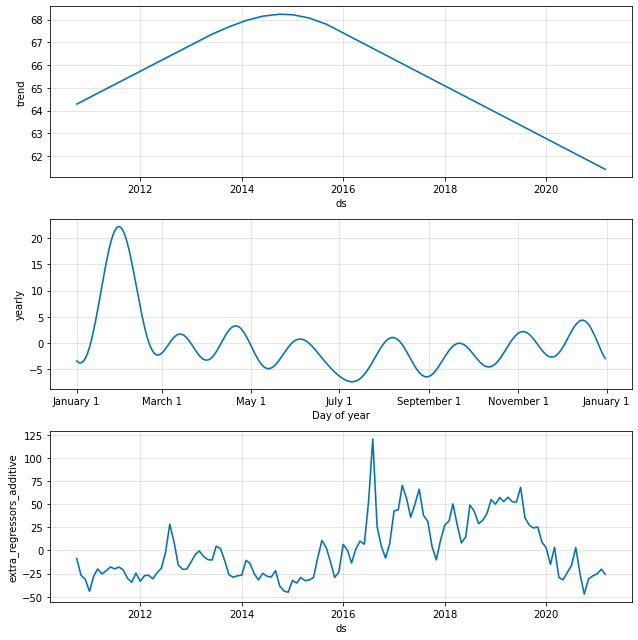

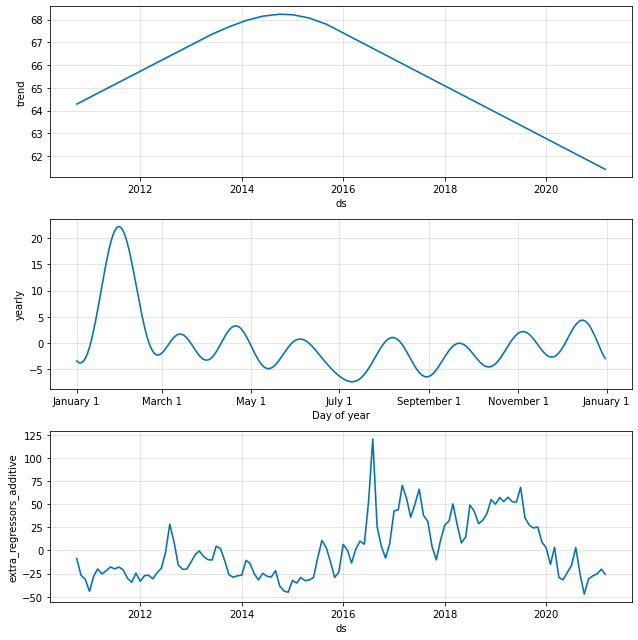

In [33]:
forwardfill_future_reg = future_reg.fillna(method='ffill')
forwardfill_forecast_reg = model_reg.predict(forwardfill_future_reg)
model_reg.plot_components(forwardfill_forecast_reg)

In [34]:
#3rd model training with regressors SysLoad(new1) and GasPrice(new3)
df_reg2 = df_day.copy().reset_index()
df_reg2 = df_reg2.rename(columns = {'FullDate' : 'ds', 'ElecPrice' : 'y', 'SysLoad' : 'new1', 'Tmax' : 'new2', 'GasPrice' : 'new3'})

In [35]:
#Splitting data into train and test
df_reg2_train, df_reg2_test = df_reg2[:2757], df_reg2[2757:]
df_reg2_train_y, df_reg2_test_y = df_reg.y[:2757], df_reg.y[2757:]

In [36]:
#Training using Prophet and adding the two regressors
model_reg2 = Prophet()
model_reg2.add_regressor('new1')
model_reg2.add_regressor('new3')
model_reg2.fit(df_reg2_train)
future_reg2 = model_reg2.make_future_dataframe(len(df_reg_test), freq = 'D')
future_reg2['new1'] = df_reg2_train['new1']
future_reg2['new3'] = df_reg2_train['new3']
future_reg2 = future_reg2.fillna(method='ffill')
#Predict for the next 12 months
forecast_reg2 = model_reg2.predict(future_reg2)
forecast_reg2

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,extra_regressors_additive,...,new3,new3_lower,new3_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2010-09-30,64.307480,28.017933,81.561753,64.307480,64.307480,-10.073712,-10.073712,-10.073712,-8.627398,...,-36.664028,-36.664028,-36.664028,-1.446314,-1.446314,-1.446314,0.0,0.0,0.0,54.233768
1,2010-10-31,64.405297,13.782110,63.862623,64.405297,64.405297,-25.415759,-25.415759,-25.415759,-26.816739,...,-48.378007,-48.378007,-48.378007,1.400980,1.400980,1.400980,0.0,0.0,0.0,38.989537
2,2010-11-30,64.499958,6.489649,57.964699,64.499958,64.499958,-32.694619,-32.694619,-32.694619,-30.890118,...,-55.569435,-55.569435,-55.569435,-1.804501,-1.804501,-1.804501,0.0,0.0,0.0,31.805339
3,2010-12-31,64.597774,-8.081081,43.430826,64.597774,64.597774,-47.469831,-47.469831,-47.469831,-44.167804,...,-54.373696,-54.373696,-54.373696,-3.302027,-3.302027,-3.302027,0.0,0.0,0.0,17.127944
4,2011-01-31,64.695591,33.903096,84.918875,64.695591,64.695591,-5.031699,-5.031699,-5.031699,-27.434269,...,-46.603025,-46.603025,-46.603025,22.402570,22.402570,22.402570,0.0,0.0,0.0,59.663892
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,2020-10-31,61.749148,6.755625,57.370802,61.749148,61.749148,-29.447050,-29.447050,-29.447050,-30.964958,...,-6.692359,-6.692359,-6.692359,1.517908,1.517908,1.517908,0.0,0.0,0.0,32.302098
122,2020-11-30,61.653290,6.318013,58.064634,61.653290,61.653290,-29.303972,-29.303972,-29.303972,-27.709415,...,0.245332,0.245332,0.245332,-1.594557,-1.594557,-1.594557,0.0,0.0,0.0,32.349318
123,2020-12-31,61.554237,6.287267,57.904109,61.554237,61.554237,-29.143417,-29.143417,-29.143417,-25.630552,...,4.772304,4.772304,4.772304,-3.512865,-3.512865,-3.512865,0.0,0.0,0.0,32.410820
124,2021-01-31,61.455184,37.825094,88.217233,61.455184,61.455184,1.904527,1.904527,1.904527,-20.415432,...,5.953555,5.953555,5.953555,22.319959,22.319959,22.319959,0.0,0.0,0.0,63.359711


In [37]:
#Measuring model without regressor performance using MAPE, RMSE
import numpy as np
def mape(actual, predicted):
  actual, predicted = np.array(actual), np.array(predicted)
  return np.mean(np.abs((actual - predicted) / actual)) * 100
actual = y_train
predicted = forecast['yhat'][:2757]
mape(actual, predicted)

44.00918305563158

In [38]:
import sklearn
from sklearn.metrics import mean_squared_error
import math
from math import sqrt

actual = y_train
predicted = forecast['yhat'][:2757]

mse = sklearn.metrics.mean_squared_error(actual, predicted)

rmse = math.sqrt(mse)

print(rmse)

31.157858608235458


In [48]:
#Measuring regressor model using MAPE and RMSE
def mape(actual, pred):
  actual, pred = np.array(actual), np.array(pred)
  return np.mean(np.abs((actual - pred) / actual)) * 100
actual_regs = df_reg_y_train
predicted_regs = forwardfill_forecast_reg['yhat'][:2757]
mape(actual_regs, predicted_regs)

25.685096926822776

In [47]:
actual_reg = y_train
predicted_reg = forwardfill_forecast_reg['yhat'][:2757]

mse = sklearn.metrics.mean_squared_error(actual_reg, pred_reg)

rmse = math.sqrt(mse)

print(rmse)

19.83874960261326
